In [1]:
import pint.models as model
import pint.toa as toa
import pint.logging
import pint.fitter
from pint.modelutils import model_ecliptic_to_equatorial
import numpy as np
import astropy.units as u
import astropy.constants as c
import pint.derived_quantities as dq
import table_utils as tu
from scipy.special import fdtrc
import matplotlib.pyplot as plt

import matplotlib as mpl
plt.rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
params = {'text.usetex'       : True,
          'axes.unicode_minus': True}
mpl.rcParams.update(params)

pint.logging.setup(level="ERROR")

1

**J1816+4510 eclipsing calculations**

For J1816+4510, we see additional delays around superior conjuntion at 820 MHz, probably due to additional electron content around the companion that the signal must travel through when the pulsar eclipses. First I want to figure out the DM bump corresponding to this delay (roughly 800 microseconds).

In [2]:
def SC_dDM(dt,freq):
    """ Calculate additional column density at superior conjunction (given additional timing delay)
    
    Parameters
    ==========
    dt: quantity, additional dispersive timing delay due to plasma around companion
    freq: quantity, observing frequency of measured delay
    
    Returns
    =======
    dDM_sup: quantity, additional column density at superior conjunction (cm^-2)
    """
    Dconst = 4.148808e3*(1e6*u.Hz)**2*u.cm**3*u.s*u.pc**-1 # HBOPA, eqn. 4.6
    dDM_sup = (dt*freq**2/Dconst).to(u.pc*u.cm**-3) # extra DM corresponding to delay
    return dDM_sup.to(u.cm**-2)

To compare to a similar calculation in Freire (2005; ASPCS, p. 407), I convert DM (column density) to 1/cm^2. The result is comparable to the column density of J2051-0827 (Stappers et al. 2001).

In [3]:
dDM_1816 = SC_dDM(800.0*1e-6*u.s,820.0*(1e6*u.Hz))
print(dDM_1816)
print(dDM_1816.to(u.pc*u.cm**-3))

4.0007821153349005e+17 1 / cm2
0.12965651820956764 pc / cm3


How big might the companion be based on the duration of the eclipse? Assume inclination angle of 90 deg for now, and consider an eclipse that lasts some fraction of an orbit (based on gap between ingress-egress).

In [4]:
def psr_comp_separation(model,inc=90.0*u.deg,mp=1.4*u.solMass):
    """ Calculate separation between pulsar and binary companion
    
    Parameters
    ==========
    model: object, PINT timing model
    inc: quantity, assumed orbital inclination (optional, default = 90 deg)
    mp: quantity, assumed pulsar mass (optional, default = 1.4 Msun)
    """
    mc = dq.companion_mass(mo['PB'].quantity, mo['A1'].quantity, i=inc, mp=mp)
    return (mo['A1'].quantity/np.sin(inc)).to(u.R_sun)*(1+(mp/mc))

def Rplasma(a, frac_eclipse):
    """ Estimate companion (plasma?) radius based on extent of eclipse
    
    Parameters
    ==========
    a: quantity, separation between the pulsar and companion
    frac_eclipse: float, fraction of the orbit where pulsar signal is obscured
    
    Returns
    =======
    Rplasma: quantity, companion's plasma(?) radius (Solar Radii)
    """
    print(f"Nominal pulsar-companion separation: {a.value:.4f} Rsun")
    ing2sup = frac_eclipse*180.0*u.deg # angle from ingress to superior conjunction
    Rplasma = a*np.sin(ing2sup)
    print(f"Companion's estimated plasma radius: {Rplasma.value:.4f} Rsun ({Rplasma.to(u.km).value:.0f} km)")
    return Rplasma

frac_eclipse = 0.04

par_path = f"data/J1816+4510_eclipseDMX.par"
tim_path = f"data/J1816+4510_eclipseDMX.tim"
mo = model.get_model(par_path)
to = toa.get_TOAs(tim_path,model=mo)
fo = pint.fitter.WLSFitter(to,mo)
x = fo.fit_toas()
a = psr_comp_separation(mo, mp=1.64*u.solMass) # using lower limit on M_psr from Clark et al. (2023)
print(f"J1816+4510 is obscured for {frac_eclipse:.0%} of an orbit...")
rp = Rplasma(a,frac_eclipse)

J1816+4510 is obscured for 4% of an orbit...
Nominal pulsar-companion separation: 2.6041 Rsun
Companion's estimated plasma radius: 0.3264 Rsun (227061 km)


I can use the estimated companion's plasma radius to get some idea of the electron density near the companion (using the additional column density around superior conjunction). This is probably ~order of magnitude.

In [5]:
(dDM_1816/rp).to(u.cm**-3)

<Quantity 17619863.47492632 1 / cm3>

Next, I want to use the equation from Eggleton et al. (1983) to estimate the size of the companion's Roche Lobe, and thus, the path length the pulsar might be encountering around superior conjunction. Do this for a few possible inclination angles and assume pulsar mass is 1.64 solar masses.

In [6]:
def RL_Eggleton(a,mc,mp=1.4*u.solMass):
    """ Calculate Roche Lobe size in solar radii (see Eggleton 1983)
    
    Parameters
    ==========
    a: quantity, separation between the pulsar and companion
    mc: quantity, companion mass (solar masses)
    mp: pulsar mass (default: 1.4 Msun), optional
    
    Returns
    =======
    R_L: quantity, Roche Lobe size (solar radii)
    """
    q = mc/mp
    R_L = 0.49*a*q**(2.0/3)/(0.6*q**(2.0/3)+np.log(1.0+q**(1.0/3)))
    return R_L.to(u.R_sun)

incs = [90.0,85.0,80.0,75.0] # trial inclination angles, degrees

mo = model.get_model(par_path)
to = toa.get_TOAs(tim_path,model=mo)
fo = pint.fitter.WLSFitter(to,mo)
x = fo.fit_toas()

for inc in incs:
    mp = 1.64*u.M_sun
    a = psr_comp_separation(mo,inc=inc*u.deg,mp=mp)
    mc = dq.companion_mass(mo['PB'].quantity, mo['A1'].quantity, i=inc*u.deg, mp=mp)
    R_L = RL_Eggleton(a,mc,mp=mp)
    RlRp_ratio = R_L/rp

    mc_str = f"{mc.value:.4f}"
    q_str = f"{mc/mp:.4f}"
    a_str = f"{a.value:.4f}"
    rl_str = f"{R_L.value:.5f}"
    rlrp_str = f"{RlRp_ratio:.2f}"

    print(f"  i = {inc} deg; mc = {mc_str} Msun; q = {q_str}; a = {a_str} Rsun; RL = {rl_str} Rsun; RL/Rp = {rlrp_str}")

  i = 90.0 deg; mc = 0.1792 Msun; q = 0.1093; a = 2.6041 Rsun; RL = 0.55252 Rsun; RL/Rp = 1.69
  i = 85.0 deg; mc = 0.1800 Msun; q = 0.1097; a = 2.6044 Rsun; RL = 0.55324 Rsun; RL/Rp = 1.70
  i = 80.0 deg; mc = 0.1822 Msun; q = 0.1111; a = 2.6055 Rsun; RL = 0.55544 Rsun; RL/Rp = 1.70
  i = 75.0 deg; mc = 0.1860 Msun; q = 0.1134; a = 2.6073 Rsun; RL = 0.55917 Rsun; RL/Rp = 1.71


Therefore (unlike the systems considered in Freire 2005), the Roche Lobe (R_L above) is somewhat larger than the size of the plasma cloud (R_p), so matter responsible for increased dispersive delays is bound to the companion.

**Optical Constraints Calculations**

I follow a procedure similar to that described in Section 4.7 of Swiggum et al. (2023) / Section 7 of Lynch et al. (2018).

In [7]:
# reddening in PS1 bands from Schlafly & Finkbeiner 2011, Table 6
# grizy
ps1_redden=np.array([3.172,2.271,1.682,1.322,1.087]) # y not constraining?

# assume no detection.  Typical PS1 grizy stack limits are:
ps1_lims = np.array([23.3,23.2,23.1,22.3,21.4])

# extinction from http://argonaut.skymaps.info (see Green et al. 2015)
# these take distance (largest NE vs. YMW) into account
psr = "J0032+6946"
extinction = 0.91

par_path = f"data/{psr}_fiore+23.par"
mo = model.get_model(par_path)

mp = 1.4*u.Msun

pb = (1./mo['FB0'].quantity).to(u.day)

mcmax = dq.companion_mass(pb, mo['A1'].quantity, i=26.0*u.deg, mp=mp)
mcmed = dq.companion_mass(pb, mo['A1'].quantity, i=60.0*u.deg, mp=mp)
mcmin = dq.companion_mass(pb, mo['A1'].quantity, i=90.0*u.deg, mp=mp)

gcoord = mo.coords_as_GAL()
dmdist_ne, dmdist_ymw = tu.get_dmdists(gcoord,mo['DM'].value)

dmdist = max([dmdist_ne,dmdist_ymw])

distance_mod = 5*np.log10((dmdist*u.kpc/(10.0*u.pc)).decompose())

print(f"{psr}: {mcmin.value:.3f}-{mcmed.value:.3f}-{mcmax.value:.3f} Msun")
grizy_lims = ps1_lims-extinction*ps1_redden-distance_mod # de-reddened limits
print(grizy_lims)

J0032+6946: 0.417-0.496-1.212 Msun
[8.15744868 8.87735868 9.31334868 8.84094868 8.15479868]


In [9]:
import matplotlib.pyplot as plt
from astropy.units import cds

# > 0.3 Msun, WD behaves nicely (cold degenerate matter), has mass-radius relationship
# type of atmosphere can change, H (DA) vs. He (DB)
# abs. magnitude depends on surface temperature, which depends on age & mass (cooling models)
# with PanSTARRS nondetection, limit M -> limit Teff -> limit age for a given mass

m = 0.4956
psr = "J0032+6946"

#m, psr= ms[0], psrs[0]

# read in Bergeron tables (https://www.astro.umontreal.ca/~bergeron/CoolingModels/)

def COlimit(maglims,atmo="DA",m="0.4"):
    check_rows = np.loadtxt(f'data/berg{m}.txt',dtype=str,usecols=2)
    dbrow = np.max(np.where(check_rows=="Mo"))
    if atmo=="DA":
        teffs, g, r, i, z, y, ages = np.loadtxt(f'data/berg{m}.txt',dtype=str,skiprows=2,max_rows=dbrow-2, 
                                                usecols=[0,29,30,31,32,33,42],unpack=True)
        parenthesis = "(DA / H atmosphere)"
    elif atmo=="DB":
        teffs, g, r, i, z, y, ages = np.loadtxt(f'data/berg{m}.txt',dtype=str,skiprows=dbrow+3, 
                                                usecols=[0,29,30,31,32,33,42],unpack=True)
        parenthesis = "(DB / He atmosphere)"
    else:
        print("Atmosphere must be 'DA' or 'DB'")
        return
    grizydata = [g,r,i,z,y]
    bands = ['g','r','i','z','y']
    teff_lims = []
    age_lims = []
    for band, maglim, bergmags in zip(bands, maglims, grizydata):
        idx = (np.abs(maglim - np.array(bergmags).astype(float))).argmin()
        teff, age = teffs[idx], ages[idx]
        teff_lims.append(float(teff))
        age_lims.append(float(age))
        #print(f"{psr}: using values for {m} Msun, {band} band, cooling age {age} yr: {teff} K")
    idx = np.argmin(np.array(teff_lims))
    print(f"{psr}: Mc = {m} Msun, {bands[idx]}-band limited (M_{bands[idx]} < {maglims[idx]:.1f}), cooling age {age_lims[idx]*10**-6:.2f} Myr: {teff_lims[idx]:.0f} K {parenthesis}")

In [10]:
for mass in [0.4,0.5,0.6]:
    COlimit(maglims=grizy_lims,atmo="DA",m=str(mass))
    COlimit(maglims=grizy_lims,atmo="DB",m=str(mass))

J0032+6946: Mc = 0.4 Msun, r-band limited (M_r < 8.9), cooling age 0.94 Myr: 35000 K (DA / H atmosphere)
J0032+6946: Mc = 0.4 Msun, i-band limited (M_i < 9.3), cooling age 0.44 Myr: 40000 K (DB / He atmosphere)
J0032+6946: Mc = 0.5 Msun, r-band limited (M_r < 8.9), cooling age 1.74 Myr: 45000 K (DA / H atmosphere)
J0032+6946: Mc = 0.5 Msun, r-band limited (M_r < 8.9), cooling age 1.70 Myr: 47500 K (DB / He atmosphere)
J0032+6946: Mc = 0.6 Msun, r-band limited (M_r < 8.9), cooling age 1.51 Myr: 55000 K (DA / H atmosphere)
J0032+6946: Mc = 0.6 Msun, i-band limited (M_i < 9.3), cooling age 1.40 Myr: 60000 K (DB / He atmosphere)


In [11]:
# reddening in PS1 bands from Schlafly & Finkbeiner 2011, Table 6
# grizy
ps1_redden=np.array([3.172,2.271,1.682,1.322,1.087]) # y not constraining?

# assume no detection.  Typical PS1 grizy stack limits are:
ps1_lims = np.array([23.3,23.2,23.1,22.3,21.4])

# extinction from http://argonaut.skymaps.info (see Green et al. 2015)
# these take distance (largest NE vs. YMW) into account
psr = "J1239+3239"
extinction = 0.02

par_path = f"data/{psr}_fiore+23.par"
mo = model.get_model(par_path)

mp = 1.4*u.Msun

pb = (1./mo['FB0'].quantity).to(u.day)

mcmax = dq.companion_mass(pb, mo['A1'].quantity, i=26.0*u.deg, mp=mp)
mcmed = dq.companion_mass(pb, mo['A1'].quantity, i=60.0*u.deg, mp=mp)
mcmin = dq.companion_mass(pb, mo['A1'].quantity, i=90.0*u.deg, mp=mp)

gcoord = mo.coords_as_GAL()
dmdist_ne, dmdist_ymw = tu.get_dmdists(gcoord,mo['DM'].value)

dmdist = max([dmdist_ne,dmdist_ymw])
print(f"{dmdist} kpc")

distance_mod = 5*np.log10((dmdist*u.kpc/(10.0*u.pc)).decompose())

print(f"{psr}: {mcmin.value:.3f}-{mcmed.value:.3f}-{mcmax.value:.3f} Msun")
grizy_lims = ps1_lims-extinction*ps1_redden-distance_mod # de-reddened limits
print(grizy_lims)

2.232192138671875 kpc
J1239+3239: 0.126-0.147-0.310 Msun
[11.49290213 11.41092213 11.32270213 10.52990213  9.63460213]


In [12]:
# Kilic et al. (2021) WD sample
kilic_teff, kilic_teff_err, kilic_logg, kilic_logg_err, kilic_M, kilic_M_err = np.loadtxt("data/kilic+21_wdparams.dat",dtype=str,skiprows=5,usecols=[3,4,5,6,7,8],delimiter='|',unpack=True)
for i,te in enumerate(kilic_teff_err):
    try:
        test = float(te)
    except ValueError:
        kilic_teff_err[i] = "0"

kilic_R = np.sqrt(c.G * kilic_M.astype(float)*u.Msun / ((u.cm/u.s/u.s) * 10 ** kilic_logg.astype(float)))
kilic_R_err = (kilic_R/2) * np.sqrt((kilic_M_err.astype(float)/kilic_M.astype(float))**2 + (np.log(10)*kilic_logg_err.astype(float))**2)

# Kilic et al. (2022) ELM WDs

elm_teff, elm_teff_err, elm_logg, elm_logg_err, elm_M, elm_M_err = np.loadtxt("data/kilic+22_elm.dat",dtype=str,skiprows=46,usecols=[15,16,17,18,19,20],unpack=True)
for i,te in enumerate(elm_teff_err):
    try:
        test = float(te)
    except ValueError:
        elm_teff_err[i] = "0"

elm_R = np.sqrt(c.G * elm_M.astype(float)*u.Msun / ((u.cm/u.s/u.s) * 10 ** elm_logg.astype(float)))
elm_R_err = (elm_R/2) * np.sqrt((elm_M_err.astype(float)/elm_M.astype(float))**2 + (np.log(10)*elm_logg_err.astype(float))**2)

# # some ELM WDs from Althaus et al. (2013) (redundant with Kilic+22, older)
# althaus_teff, althaus_teff_err, althaus_logg, althaus_logg_err, althaus_M, althaus_M_err = np.loadtxt("data/althaus+13_knownwds.dat",dtype=str,usecols=[1,2,3,4,5,6],unpack=True)

# althaus_R = np.sqrt(c.G * althaus_M.astype(float)*u.Msun / ((u.cm/u.s/u.s) * 10 ** althaus_logg.astype(float)))
# althaus_R_err = (althaus_R/2) * np.sqrt((althaus_M_err.astype(float)/althaus_M.astype(float))**2 + (np.log(10)*althaus_logg_err.astype(float))**2)

In [13]:
def Helimit(maglims,radii,masses,atmo,tscale,max_DB_radius,save=False):
    if type(atmo) is not list:
        atmo = [atmo]
    lstyles = ['-','--'][:len(atmo)]
    maxRs = np.array([max(radii).value,max_DB_radius])*u.Rsun
    for atm,ls,maxR in zip(atmo,lstyles,maxRs):
        if type(masses) is not list:
            masses = [masses]
        for m in masses:
            check_rows = np.loadtxt(f'data/berg{m:.1f}.txt',dtype=str,usecols=2)
            dbrow = np.max(np.where(check_rows=="Mo"))
            if atm=="DA":
                teffs, logg, g, r, i, z, y, ages = np.loadtxt(f'data/berg{m:.1f}.txt',dtype=str,skiprows=2,max_rows=dbrow-2, 
                                                        usecols=[0,1,29,30,31,32,33,42],unpack=True)
                parenthesis = "(DA / H atmosphere)"
            elif atm=="DB":
                teffs, logg, g, r, i, z, y, ages = np.loadtxt(f'data/berg{m:.1f}.txt',dtype=str,skiprows=dbrow+3, 
                                                        usecols=[0,1,29,30,31,32,33,42],unpack=True)
                parenthesis = "(DB / He atmosphere)"
            else:
                print(f"What is {atmo}? Atmosphere must be 'DA' or 'DB'")
                return
            grizydata = [g,r,i,z,y]
            bands = ['g','r','i','z','y']
            
            Rs = np.array([])*u.Rsun
            for lg in logg:
                R = np.sqrt(c.G*m*u.Msun / ((10**float(lg))*u.cm*u.s**-2))
                Rs = np.append(Rs, R.to(u.Rsun))
            
            lessmaxR = radii <= maxR
            radii_trimmed = radii[lessmaxR]
            
            teff_lims = False
            for maglim, bergmags in zip(maglims[:3], grizydata):
                teff_new = np.array([])
                for new_r in radii_trimmed:
                    new_mags = np.array(bergmags.astype(float)) - 2.5*np.log10(((new_r/Rs).to(u.Rsun/u.Rsun))**2)
                    idx = (np.abs(maglim - new_mags.astype(float))).argmin()
                    teff = teffs[idx]
                    teff_new = np.append(teff_new,float(teff))
                try:
                    teff_lims = np.vstack((teff_lims,teff_new))
                except ValueError:
                    teff_lims = teff_new
            min_teff_lims = np.amin(teff_lims, axis=0)
            #print(radii_trimmed, min_teff_lims)
            plt.plot(radii_trimmed,min_teff_lims/tscale,c='black',ls=ls,lw=1,label=f"{atm} atmosphere")
    
    elm_col = 'b'
    #elm_label = ''
    elm_label = r'Brown et al.~(2022)'
    plt.errorbar(elm_R.to(u.Rsun),elm_teff.astype(float)/tscale,xerr=elm_R_err,yerr=elm_teff_err.astype(float)/tscale, \
                 fmt='o',mfc=elm_col,mec=elm_col,ecolor=elm_col,ms=1.5,capsize=1.,elinewidth=0.5, \
                 label=elm_label,alpha=0.6,zorder=1)
    
    kilic_col = 'gray'
    #kilic_label = ''
    kilic_label = r'Kilic et al.~(2020)'
    plt.errorbar(kilic_R.to(u.Rsun),kilic_teff.astype(float)/tscale,xerr=kilic_R_err,yerr=kilic_teff_err.astype(float)/tscale, \
                 fmt='o',mfc=kilic_col,mec=kilic_col,ecolor=kilic_col,ms=1.5,capsize=1.,elinewidth=0.5, \
                 label=kilic_label,alpha=0.6,zorder=1)
    
    #plt.loglog()
    plt.xscale('log')
    plt.xlabel(r"WD Radius (R$_\odot$)",fontsize=20)
    plt.ylabel(r"$T_\mathrm{eff}$ ($10^3$\,K)",fontsize=20)
    plt.xlim(min_radius, max_radius)
    plt.ylim(0.0,31000.0/tscale)
    plt.tick_params(axis='both', labelsize=16)
    #plt.legend(fontsize=13,ncol=2,columnspacing=0.8,framealpha=0.4,labelspacing=0.4)
    plt.legend(fontsize=14)
    #plt.grid(True)
    if save:
        plt.savefig("J1239_opticalconstraints.pdf",format="pdf",bbox_inches='tight',pad_inches=0.25)

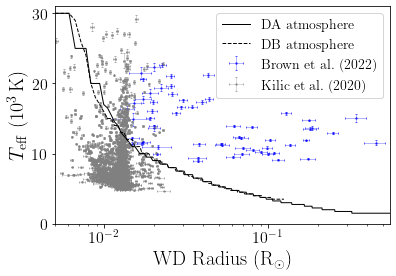

In [14]:
min_radius = 0.005
max_radius = 0.55
radii = np.linspace(min_radius,max_radius,1000)*u.Rsun
Helimit(grizy_lims,radii,masses=0.2,atmo=["DA","DB"],tscale=1000,max_DB_radius=0.125,save=False)